# Section 3: ML API

Deploy (on a cloud provider [AWS, Azure, etc] or locally [docker, kubernetes, etc] ) an ML model ([MNIST](https://paperswithcode.com/dataset/mnist), [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), as an API endpoint. Provide reproducible code with documentation for both deployment and usage.

Notes: procedure and code adapted from https://towardsdatascience.com/serverless-deployment-of-machine-learning-models-on-aws-lambda-5bd1ca9b5c42

## Introduction

This code deploys a machine learning model as a lambda function.

## Steps:
1. Set up the working environment by integrating AWS CLI on our machine and initialize a S3 bucket as a data store.
2. Train a K-Nearest Neighbor classifier which we will deploy as a docker container
3. Deploy as a lambda function with AWS SAM

## Step 1: Prerequisites

1. [AWS account](https://aws.amazon.com/free)
2. [AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html) and [Set up AWS CLI](https://medium.com/@lloyd.hamilton/setting-up-aws-cli-credentials-65d0a5fc0c4e)
3. [AWS Serverless Application Model CLI](https://docs.aws.amazon.com/serverless-application-model/latest/developerguide/serverless-sam-cli-install.html)
4. [Docker](https://docs.docker.com/get-docker/)
5. [Python 3.9.7](https://www.python.org/downloads/release/python-397/)
6. [Poetry](https://python-poetry.org/) for Python package management tool
7. Python libraries: the requirements.txt file is included in the Git repository
8. [Project repository](https://github.com/albertlok/predict-app-api): https://github.com/albertlok/predict-app-api

## Step 2: Train KNN Classifier, validate the model, and save locally

(-0.5, 27.5, 27.5, -0.5)

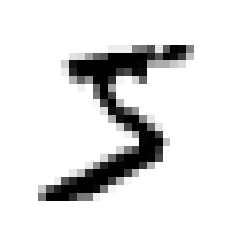

In [3]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import pandas as pd

# Load data
mnist = fetch_openml("mnist_784", version=1)

# Get data from original dataset
mnist_data = (
    mnist
    .data
)

# Slice target by the same row sampling
target = (
    mnist
    .target
    .loc[mnist_data.index].astype('uint8')
)

# Reshape values to be 28x28
some_digit_image = (
    mnist_data
    .iloc[0]
    .values
    .reshape(28,28)
    .astype('float32')
)
plt.imshow(some_digit_image, cmap = "binary")
plt.axis("off")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Function to train KNN Classifier and show scores
def train_knn_model(features:np.array, target:np.array):

    # Train KNN Classifier
    knnclf = KNeighborsClassifier(weights='distance', n_neighbors=4)
    knnclf.fit(features, target)
    scores = cross_val_score(
        knnclf, features, target, scoring='accuracy', cv=10
    )
    print(f'Cross Validation Scores: {scores}')
    print(f'Average accuracy: {np.mean(scores)}')
    return knnclf, scores

# Split data to training and test set
train_features, test_features, train_target, test_target = train_test_split(
        mnist_data, target, test_size = 0.2, random_state = 42
)
knnclf, scores = train_knn_model(train_features, train_target)

Cross Validation Scores: [0.97053571 0.97178571 0.97357143 0.97357143 0.97571429 0.97571429
 0.97767857 0.97035714 0.97285714 0.97125   ]
Average accuracy: 0.9733035714285713


Validation shows an accuracy of 97%.  Now we evaluate the model's performance on the test_features data set and plot a confusion matrix with the show_cm function as shown below.

Accuracy: 0.9731428571428572


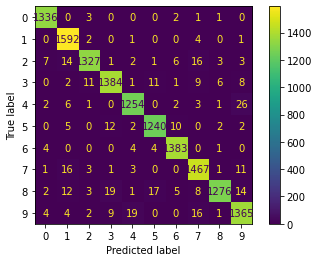

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def show_cm(y_true, y_pred, labels):

    # Display Confusion matrix and show accuracy scores
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
    score = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {score}')
    disp.plot();

# Make predictions
test_target_pred = knnclf.predict(test_features)
# Show confusion matrix
show_cm(test_target, test_target_pred, range(10))

In [6]:
# save the model locally to be containerized as part of the lambda function using Docker.

import joblib

joblib.dump(knnclf, 'app/knnclf.joblib')

['app/knnclf.joblib']

## Step 3: Deploy as a lambda function with AWS SAM

These are the components of deployment to AWS:
1. S3 Bucket to store data.
2. API gateway to manage HTTP requests.
3. Lambda function containing the predictive logic.

![](overview.png)

#### Serverless deployment of ML models

1. Test data is uploaded to a S3 bucket.

2. To initiate the lambda function, a POST HTTP request is sent through the Amazon API Gateway. 

3. Initialisation of the lambda function executes code that downloads the data from the S3 bucket and performs predictions. 

4. A HTTP response is returned to client with the predictions as a data payload.

The Lambda function will contain Python code that performs a prediction based on the test_features dataset stored on a S3 bucket. 

***Note:*** If running all the code, the `bucket_name` has to be unique therefore you will have to replace the bucket_name with a name that is not taken.

In [ ]:
# Do not run this if using the bucket I created (recommended)
# Ensure that the AWS user has permissions to create and access S3 buckets as well as Lambda (I used root user)

import boto3

def create_bucket(region:str, bucket_name:str) -> dict:

    s3 = boto3.client('s3')
    response = s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={
            'LocationConstraint':region
        }
    )
    return response

region = 'us-west-1'
bucket_name = 'lh-lambda-buckets-2022-08-24-alok-test'
create_bucket(region, bucket_name)

#### Upload Test data to S3

The S3 bucket will host our test_features data set which we can call in our lambda function to perform a prediction.

The bucket variable defines the destination S3 bucket and the key variable will define the file path in the bucket. The `bucket` and `key` variables will form part of the data payload in the POST HTTP request to our lambda function.

In [9]:
from io import BytesIO
import joblib
import boto3

def UploadToS3(data, bucket:str, key:str):

    with BytesIO() as f:
        joblib.dump(data, f)
        f.seek(0)
        (
            boto3
            .client('s3')
            .upload_fileobj(Bucket=bucket, Key=key, Fileobj=f)
        )

bucket_name = 'lh-lambda-buckets-2022-08-24-alok-test'
key =  'validation/test_features.joblib'
UploadToS3(test_features, bucket_name, key)

#### List all objects in S3 bucket

We can check if the objects have been uploaded with the helper function below. list_s3_objects will list all objects in the defined bucket.

In [10]:
def listS3Objects(bucket:str) -> list:

     # Connect to s3 resource
    s3 = boto3.resource('s3')
    my_bucket = s3.Bucket(bucket)

    # List all object keys in s3 bucket
    obj_list = [object_summary.key for object_summary in my_bucket.objects.all()]
    return obj_list

listS3Objects(bucket_name)

['numpy.zip',
 'scikit-learn.zip',
 'sklearn.zip',
 'validation/test_features.joblib']

We have now successfully initialised a S3 bucket to store the test_feature data.

The next two key resources, API Gateway and lambda function, will be deployed using AWS Serverless Application Model (SAM).

#### Deploying on AWS Lambda

Steps:
1. Build the application in SAM.

```bash
`sam build -t template.yaml`
```

2. Deploy the application.

```bash
`sam deploy --guided`
```

Follow the prompts that guides you through the deployment configurations.

3.  If running in your own AWS account, invoke your function by replacing the URL in the code below with the URL from the output out of a successfully deployed stack.

Accuracy: 0.9731428571428572


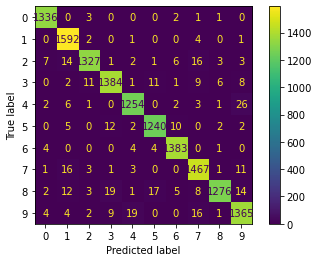

In [11]:
import requests
import json
import numpy as np

bucket_name = 'lh-lambda-buckets-2022-08-24-alok-test'
key =  'validation/test_features.joblib'

data = {
    'bucket':bucket_name,
    'key':key,
}

headers = {
    'Content-type': "application/json"
}

# Main code for post HTTP request
url = "https://b6lornzdwgu54gjsy2zaryoux40fxfxn.lambda-url.us-west-1.on.aws/"
response = requests.request("POST", url, headers=headers, json=data)
lambda_predictions = np.array(response.json())
show_cm(test_target, lambda_predictions, range(10))

In [13]:
#### Export of Jupyter notebook
!jupyter nbconvert README-predict-app-api.ipynb --to html --template classic

[NbConvertApp] Converting notebook README-predict-app-api.ipynb to html
[NbConvertApp] Writing 330613 bytes to README-predict-app-api.html
